# Riboswitch epistasis analysis notebook
### Generates figures for "Distinguishing Contact and Ensemble Epistasis in an RNA switch"
#### Daria R. Wonderlick, Julia R. Widom, Michael J. Harms

## Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter,FormatStrFormatter
from scipy import optimize
import pickle, copy, os, sys, glob
from tqdm import tqdm

import likelihood

import kapp_one_param
import two_state_three_param
import three_state_three_param
import three_state_four_param
import four_state_five_param

import warnings
#RuntimeWarning: divide by zero encountered in double_scalars
warnings.filterwarnings("ignore", category=RuntimeWarning) 

# Some pretty plot defaults
font = {'weight' : 'normal',
        'size'   : 16,
        'family' : 'Arial'}  

matplotlib.rc('font', **font)

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False


# 2AP_raw.csv contains raw 2AP binding data for mutant cycles
# 2AP_avg.csv contains averaged 2AP binding data for mutant cycles
# 2AP_corrected.csv contains 2AP binding data with low Mg and low RNA normalized to 0 fx_A

## Genotypes and mutant cycles

In [2]:
GENOS = ['xxxxx','xCxxx','xxAxx','Uxxxx',
         'xxxGx','xCxGx','xxAGx','UxxGx']

GENO_DICT = {'xxxxx':'WT','xCxxx':'C','xxAxx':'A','Uxxxx':'U',
             'xxxGx':'G','xCxGx':'GC','xxAGx':'GA','UxxGx':'GU'}

CYCLES = ['GC','GA','GU']

cycle_GC = ['xxxxx','xxxGx','xCxxx','xCxGx'] 
cycle_GA = ['xxxxx','xxxGx','xxAxx','xxAGx']
cycle_GU = ['xxxxx','xxxGx','Uxxxx','UxxGx']

CYCLE_DICT = {'GC':cycle_GC,'GA':cycle_GA,'GU':cycle_GU}

## Constants

In [18]:
R = 1.987e-3                                                           # kcal/mol-K
T = 27 + 273.15                                                        # K
BETA = 1 / (R*T)                                                       # kcal/mol

# Total Rna, Ade, and Mg2+ concentrations in different units

RNA_M = 1e-6                                                           # 1000 nM Rt
ADE_M = 50e-9                                                          # 50 nM At
MG_LIST_M = [0.1e-3,1e-3,10e-3,100e-3]                                 # 0.1,1,10,100 mM Mt
MG_RANGE_M = np.exp(np.linspace(np.log(0.1e-3),np.log(100e-3),100))    # 0.1-100 mM Mt

RNA_nM = 1000  
RNA_RANGE_nM = np.exp(np.linspace(np.log(100),np.log(10000),100))
ADE_nM = 50

MG_LIST_nM = [0.1e6,1e6,10e6,100e6]
MG_RANGE_nM = np.exp(np.linspace(np.log(0.1e6),np.log(100e6),100))

MG_LIST_mM = [0.1,1,10,100]
MG_RANGE_mM = np.exp(np.linspace(np.log(0.1),np.log(100),100))


## Import data

In [12]:
def get_model_results(model='3.3',fitter='ml',run='runs.2'):
    '''
    Generate dataframe with fit results for all genotypes 
    for a given model and fitter.
    '''
    
    fit_dir = f'../{run}'
    model_dir = os.path.join(fit_dir,model,fitter)
    if os.path.exists(model_dir):
        estimate_files = glob.glob(os.path.join(model_dir,'*results*'))
        labelled_results = []
        for file in estimate_files:
            est_df = pd.read_csv(file)
            est_df.insert(1,'Geno',[os.path.basename(file)[:5]]*est_df.shape[0])
            labelled_results.append(est_df)
        result_df = pd.concat(labelled_results)
        return result_df

    else:
        print("Could not find fit results for model", model)
        return None
    
def get_model_likelihoods(model='3.3',fitter='ml',run='runs.2'):
    '''
    Generate dataframe with fit log-likelihoods for 
    all genotypes for a given model and fitter.
    '''
    
    fit_dir = f'../{run}'
    model_dir = os.path.join(fit_dir,model,fitter)
    if os.path.exists(model_dir):
        likelihood_files = glob.glob(os.path.join(model_dir,'*likelihood*'))
        labelled_likelihoods = []
        for file in likelihood_files:
            lnL_df = pd.read_csv(file)
            lnL_df.insert(0,'Geno',[os.path.basename(file)[:5]])
            lnL_df.insert(1,'Model',[model])
            labelled_likelihoods.append(lnL_df)
        likelihood_df = pd.concat(labelled_likelihoods)
        return likelihood_df

    else:
        print("Could not find likelihoods for model", model)
        return None

def get_model_samples(model='3.3',fitter='bayesian',run='runs.2',trimmed=True,size=100):
    '''
    Generate dictionary associating genotype with fit samples for 
    all genotypes for a given model and fitter.
    
    If trimmed=True, calls get_trimmed_samples to trim array to *size*
    '''
    
    fit_dir = f'../{run}'
    model_dir = os.path.join(fit_dir,model,fitter)
    if os.path.exists(model_dir):
        sample_files = glob.glob(os.path.join(model_dir,'*samples*'))
        sample_dict = {}
        for file in sample_files:
            sample_arr = pickle.load(open(file,'rb'))
            sample_dict[os.path.basename(file)[:5]] = sample_arr
        if trimmed:
            sample_dict = get_trimmed_samples(sample_dict,model=model,size=size)
        return sample_dict

    else:
        print("Could not find samples for model", model)
        return None
    
def get_trimmed_samples(sample_dict,model,size=100):
    '''Called by get_model_samples to trim sample arrays to *size*'''
    
    trimmed_dict = {}
    for geno,sample_arr in sample_dict.items():
        
        # specific constraints on 3.3 model
        if model == '3.3':
            if geno == 'xCxxx':
                # constrain n_mg > 0.8
                sample_arr = sample_arr[np.where(sample_arr[:,2] >= 0.8)] 
            elif geno == 'xxAGx':
                # constrain abs(logK_mg) < 100
                sample_arr = sample_arr[np.where((np.abs(sample_arr[:,1]) <= 100))]
                
        # trimmed array generated from *size* entries in sample array
        trimmed_arr = sample_arr[np.random.choice(sample_arr.shape[0],size=size,replace=False)]
        trimmed_dict[geno] = trimmed_arr
        
    return trimmed_dict


## AIC test

In [13]:
def rank_likelihoods(genos=GENOS,models=['2.3','3.3','3.4','4.4','4.5','kapp']):
    '''
    Ranks ensemble models for each genotype by comparing log-likelihoods from ML fits
    Calls get_model_likelihoods to generate combined dataframe for all models
    
    Returns Dataframe sorted by genotype, then by log likelihood value of each model
    '''
    all_ll = pd.concat([get_model_likelihoods(model,'ml') for model in models])
    sorted_ll = all_ll.sort_values(by=['Geno','lnL'],ascending=[True,False])
    return sorted_ll

def calc_aic(genos=GENOS,models=['2.3','3.3','3.4','4.4','4.5','kapp']):
    '''
    Perform AIC test to determine the probability of each model based on its ML fit.
    
    AIC value for a model penalizes extra fit parameters (k) and promotes 
    high-likelihood fits across all genotypes (ll_sum)
    aic = 2*k - 2*ll_sum
    
    AIC probability reflects the probability of a given model relative to
    the model with the lowest AIC value (most probable model)
    prob = np.exp((aic_min-aic)/2)
    
    Returns sorted dataframe with aic values and aic probabilities for each model
    '''
    model_dfs = [get_model_likelihoods(model,'ml') for model in models]
    aic_df = pd.DataFrame(columns=['Model','AICvalue','AICprob'])
                           
    for i,model_df in enumerate(model_dfs):
        model = model_df.iloc[0]['Model']
        ll_sum = model_df['lnL'].sum()
        num_params = model_df.iloc[0]['N']
        aic_value = 2*num_params - 2*ll_sum
        
        aic_df.loc[i]=[model,aic_value,'NaN']
    
    aic_min = aic_df['AICvalue'].min()
    aic_df['AICprob'] = np.exp((aic_min-aic_df['AICvalue'])/2)
    aic_df = aic_df.sort_values(by='AICprob',ascending=False)
    
    return aic_df
            

In [8]:
calc_aic() 

,Model,AICvalue,AICprob
1,3.3,-1033.257381,1.000000e+00
2,3.4,-1031.257365,3.678765e-01
3,4.4,-1030.539008,2.568698e-01
4,4.5,-996.126958,8.654283e-09
0,2.3,-630.572654,3.615120e-88
5,kapp,-227.218246,9.350307e-176


## Check species concentrations

In [14]:
def conc_check(genos=GENOS,model="4.5"):
    '''
    Generates DataFrame with species concentrations based on a model's ML fit estimates
    to check whether fits reproduce total Mg2+, 2AP, and RNA concentrations.
    '''

    conc_check_df = pd.DataFrame(columns=['Geno','Model','Mt','M_free','At','A_free','Rt','fx_EA'])
    conc_check_list = []
    
    model_df = get_model_results(model=model,fitter='ml')
    
    for geno in genos:
        model_geno_df = model_df.loc[model_df.Geno == geno]
        n_mg = model_geno_df.estimate.values[-1]

        for mg_nM in MG_LIST_nM:
            if model.startswith('4'):
                E,D,EA,DA,A,M = four_state_five_param.species_conc(*model_geno_df.estimate,Rt=RNA_nM,At=ADE_nM,Mt=mg_nM,verbose=True)
                Mt = np.format_float_scientific(M+(n_mg*D)+(n_mg*DA),precision=3)
                M_free = np.format_float_scientific(M,precision=3)
                At = np.format_float_scientific(A+DA+EA,precision=3)
                A_free = np.format_float_scientific(A,precision=3)
                Rt = np.format_float_scientific(E+D+EA+DA,precision=3)
                fx_EA = np.format_float_scientific(float(EA)/float(Rt),precision=3)
                
            elif model.startswith('3'):
                if model == '3.4':
                    E,D,DA,A,M = three_state_four_param.species_conc(*model_geno_df.estimate,Rt=RNA_nM,At=ADE_nM,Mt=mg_nM,verbose=True)
                elif model == '3.3':
                    E,D,DA,A,M = three_state_three_param.species_conc(*model_geno_df.estimate,Rt=RNA_nM,At=ADE_nM,Mt=mg_nM,verbose=True)
                Mt = np.format_float_scientific(M+(n_mg*D)+(n_mg*DA),precision=3)
                M_free = np.format_float_scientific(M,precision=3)
                At = np.format_float_scientific(A+DA,precision=3)
                A_free = np.format_float_scientific(A,precision=3)
                Rt = np.format_float_scientific(E+D+DA,precision=3)
                fx_EA = np.float64(0)
                
            elif model.startswith('2'):
                E,DA,A,M = two_state_three_param.species_conc(*model_geno_df.estimate,Rt=RNA_nM,At=ADE_nM,Mt=mg_nM,verbose=True)
                Mt = np.format_float_scientific(M+(n_mg*DA),precision=3)
                M_free = np.format_float_scientific(M,precision=3)
                At = np.format_float_scientific(A+DA,precision=3)
                A_free = np.format_float_scientific(A,precision=3)
                Rt = np.format_float_scientific(E+DA,precision=3)
                fx_EA = np.float64(0)
                
            conc_check_list.append(pd.DataFrame({'Geno':[geno],'Model':[model],
                                                 'Mt':Mt,'M_free':M_free,
                                                 'At':At,'A_free':A_free,
                                                 'Rt':Rt,'fx_EA':fx_EA}))
            
    conc_check_df = pd.concat(conc_check_list)
    return conc_check_df
      

In [11]:
conc_check(model='4.5')

,Geno,Model,Mt,M_free,At,A_free,Rt,fx_EA
0,xxxxx,4.5,1.e+05,1.014e+05,5.e+01,4.41e+01,1.e+03,5.904e-03
0,xxxxx,4.5,1.e+06,1.001e+06,5.e+01,1.624e+01,1.e+03,3.376e-02
0,xxxxx,4.5,1.e+07,1.000e+07,5.e+01,9.948e+00,1.e+03,4.005e-02
0,xxxxx,4.5,1.e+08,1.000e+08,5.e+01,9.708e+00,1.e+03,4.029e-02
0,xCxxx,4.5,1.e+05,9.984e+04,5.e+01,4.834e+01,1.000e+03,1.347e-09
0,xCxxx,4.5,1.e+06,9.998e+05,5.000e+01,4.834e+01,1.e+03,9.245e-10
0,xCxxx,4.5,1.e+07,1.e+07,5.e+01,4.834e+01,1.e+03,6.345e-10
0,xCxxx,4.5,1.e+08,1.e+08,5.e+01,4.834e+01,1.e+03,4.354e-10
0,xxAxx,4.5,1.e+05,1.017e+05,5.e+01,4.997e+01,1.e+03,3.458e-05
0,xxAxx,4.5,1.e+06,1.001e+06,5.e+01,4.875e+01,1.e+03,1.253e-03


## 2AP binding curves and population plots

In [17]:
def plot_points(geno='xxxxx',ax=None,legend=False,title=None):
    '''
    Plot 2AP fractional saturation data points 
    for a given genotype from 2AP_corrected.csv.
    '''
    
    if ax is None:
        fig,ax = plt.subplots(1,1)
        plt.gcf().set_size_inches(4,4)

    plot_df = pd.read_csv('2AP_corrected.csv')
    geno_df = plot_df[plot_df.Geno == geno]  
    colors = [plt.cm.Greens(x) for x in np.linspace(0.25,1,4)]
    
    for c,mg_mM in enumerate(np.unique(geno_df.Mg)):
        m_df = geno_df[geno_df.Mg == mg_mM]
        x = m_df.Rna
        y = m_df.FS_mean
        y_err = m_df.FS_std_cutoff
        ax.errorbar(x,y,y_err,fmt='o',color=colors[c],label=str(mg_mM)+' mM Mg')
        
    ax.set_xlim(100,10000)
    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xlabel("[RNA] (nM)")
    ax.set_ylabel("Fractional 2AP Saturation")
    ax.set_ylim(0,1)
    if legend:
        ax.legend(loc='upper_left', fontsize='xx-small')
    if title is None:
        title = GENO_DICT[geno]
    ax.set_title(title)
    
    return None

def plot_estimates(geno='xxxxx',model='3.3',fitter='ml',ax=None,title=None):
    '''
    Plot 2AP fractional saturation binding curves calculated from fit
    estimates for a given genotype, model, and fitter.
    '''
    
    plot_df = pd.read_csv('2AP_corrected.csv')
    geno_df = plot_df[plot_df.Geno == geno]  
    colors = [plt.cm.Greens(x) for x in np.linspace(0.25,1,4)]

    model_df = get_model_results(model=model,fitter=fitter)
    model_geno_df = model_df.loc[model_df.Geno == geno]
    
    if ax is None:
        fig,ax = plt.subplots(1,1)
        plt.gcf().set_size_inches(4,4)
    
    for c,mg_mM in enumerate(np.unique(geno_df.Mg)):
        plot_df = pd.DataFrame({'Rna':RNA_RANGE_nM,'Mg':mg_mM})
        
        if model.startswith('4'): 
            fx_A = four_state_five_param.fx_A(*model_geno_df.estimate,some_df=plot_df)
        elif model == '3.4':
            fx_A = three_state_four_param.fx_A(*model_geno_df.estimate,some_df=plot_df)
        elif model == '3.3':
            fx_A = three_state_three_param.fx_A(*model_geno_df.estimate,some_df=plot_df)
        elif model == '2.3':
            fx_A = two_state_three_param.fx_A(*model_geno_df.estimate,some_df=plot_df)
        elif model == 'kapp':
            mg_df = model_geno_df.loc[model_geno_df.Mg == mg_mM]
            fx_A = kapp_one_param.fx_A(*mg_df.estimate,some_df=plot_df)
            fx_A_high = kapp_one_param.fx_A(*(mg_df.estimate+mg_df.stdev),some_df=plot_df)
            fx_A_low = kapp_one_param.fx_A(*(mg_df.estimate-mg_df.stdev),some_df=plot_df)
            ax.fill_between(plot_df.Rna,fx_A_low,fx_A_high,alpha=0.25,color=colors[c])
            
        ax.plot(plot_df.Rna,fx_A,lw=3,color=colors[c])
            
    ax.set_xlim(100,10000)
    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xlabel("[RNA] (nM)")
    ax.set_ylabel("Fractional 2AP Saturation")
    ax.set_ylim(0,1)
    if title is None:
        title = GENO_DICT[geno]
    ax.set_title(title)
    
    return None
    
def plot_samples(geno,model='3.3',fitter='ml',trimmed=True,
                 sample_frac=0.05,alpha=0.1,ax=None,title=None):
    '''
    Plot 2AP fractional saturation binding curves calculated from sample
    estimates for a given genotype, model, and fitter. 
    
    sample_frac determines the fraction of sample replicates to be plottted.
    '''
    
    plot_df = pd.read_csv('2AP_corrected.csv')
    geno_df = plot_df[plot_df.Geno == geno]  
    colors = [plt.cm.Greens(x) for x in np.linspace(0.25,1,4)]
    
    sample_dict = get_model_samples(model,fitter,trimmed=trimmed)
    sample_arr = sample_dict[geno]
    
    if ax is None:
        fig,ax = plt.subplots(1,1)
        plt.gcf().set_size_inches(4,4)
        
    spacing = int(sample_frac*len(sample_arr))
    
    for c,mg_mM in enumerate(np.unique(geno_df.Mg)):
        plot_df = pd.DataFrame({'Rna':RNA_RANGE_nM,'Mg':mg_mM})
        for s in range(0,len(sample_arr),spacing):
            estimates = sample_arr[s]
            
            if model.startswith('4'): 
                fx_A = four_state_five_param.fx_A(*estimates,some_df=plot_df)
            elif model == '3.4':
                fx_A = three_state_four_param.fx_A(*estimates,some_df=plot_df)
            elif model == '3.3':
                fx_A = three_state_three_param.fx_A(*estimates,some_df=plot_df)
            elif model == '2.3':
                fx_A = two_state_three_param.fx_A(*estimates,some_df=plot_df)
            elif model == 'kapp':
                print(f'Cannot plot samples for {model}')
                return None
            ax.plot(plot_df.Rna,fx_A,lw=3,alpha=alpha,color=colors[c])
            
    ax.set_xlim(100,10000)
    ax.set_xscale("log")
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_xlabel("[RNA] (nM)")
    ax.set_ylabel("Fractional 2AP Saturation")
    ax.set_ylim(0,1)
    if title is None:
        title = GENO_DICT[geno]
    ax.set_title(title)
    
    return None


def plot_groupedfits(genos=GENOS,model='3.3',fitter='ml',ml_estimates=False,
                     points=True,estimates=False,samples=False,trimmed=True,plot_kapp=False,
                     sample_frac=0.05,alpha=0.1,legend=False,savefig=False,file=None):
    '''
    Organizing scheme for plotting 2AP binding curves for 8 genotypes (two rows of 4)
    for a given model and fitter. 
    
    Can specify plotting points, fit estimates (alpha=1), or fit samples (alpha=alpha).
    
    If plotting bayesian samples, ml_estimates=True overlays the ML result.
    
    Since Kapp model has no bayesian samples, stdev region shaded with alpha=0.25
    '''

    fig, axes = plt.subplots(ncols=4,nrows=2,sharey=True,squeeze=False,figsize=(20,10)) 
    
    pbar = tqdm(range(8))
    #for i in range(num_plots):
    for i in pbar:
        geno = genos[i]
        pbar.set_description("Plotting %s" % GENO_DICT[geno])
        
        #organize subplot layout 
        j = 0
        k = i
        if i >= 4:
            j = 1
            k = i-4
            
        if samples:
            plot_samples(geno=geno,model=model,fitter=fitter,sample_frac=sample_frac,alpha=alpha,ax=axes[j,k],title=f'{GENO_DICT[geno]} ({model})')
        if estimates:
            plot_estimates(geno=geno,model=model,fitter=fitter,ax=axes[j,k],title=f'{GENO_DICT[geno]} ({model})') 
        if ml_estimates:
            plot_estimates(geno=geno,model=model,fitter='ml',ax=axes[j,k],title=f'{GENO_DICT[geno]} ({model})')    
        if points:
            plot_points(geno=geno,ax=axes[j,k],title=f'{GENO_DICT[geno]} ({model})') 
        
    fig.tight_layout()
    if savefig:
        fig.savefig(file)
        
    return None
        

Plotting GU: 100%|██████████| 8/8 [00:00<00:00, 32.91it/s]


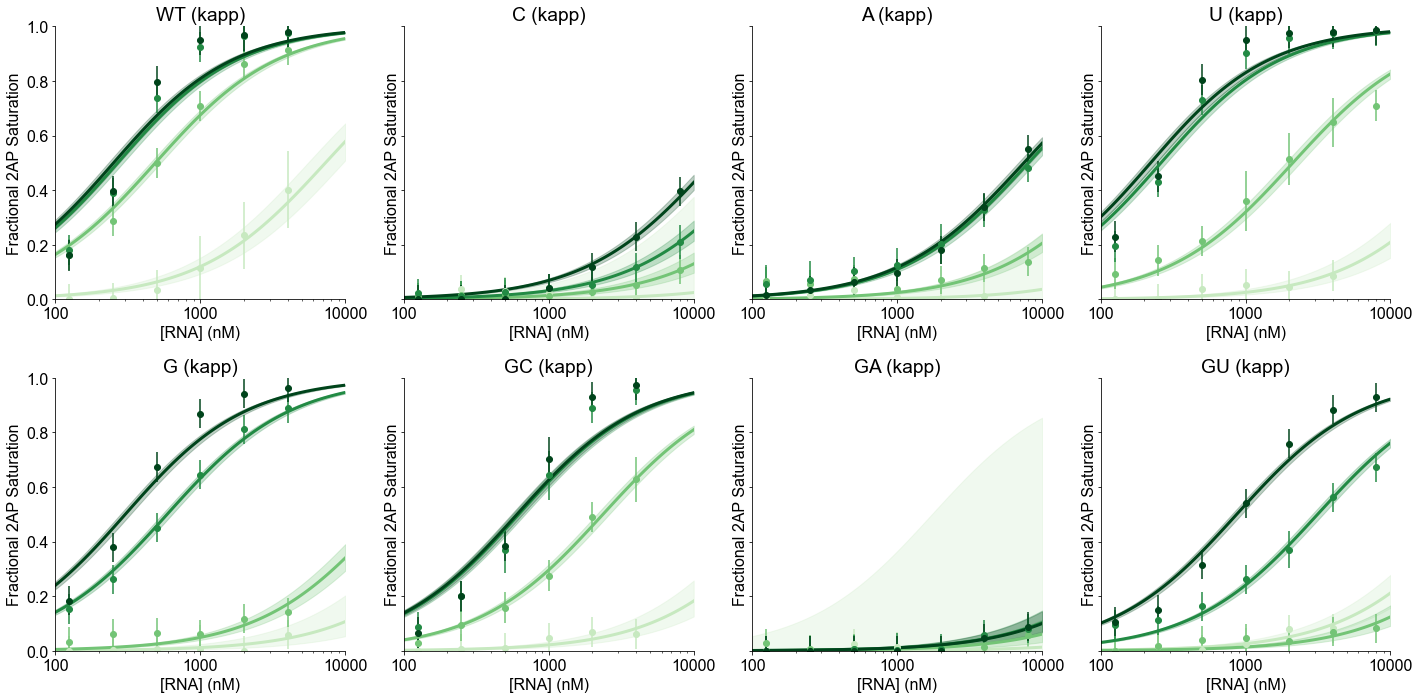

In [302]:
plot_groupedfits(model='kapp',fitter='ml',points=True,estimates=True)

Plotting GU: 100%|██████████| 8/8 [01:16<00:00,  9.59s/it]


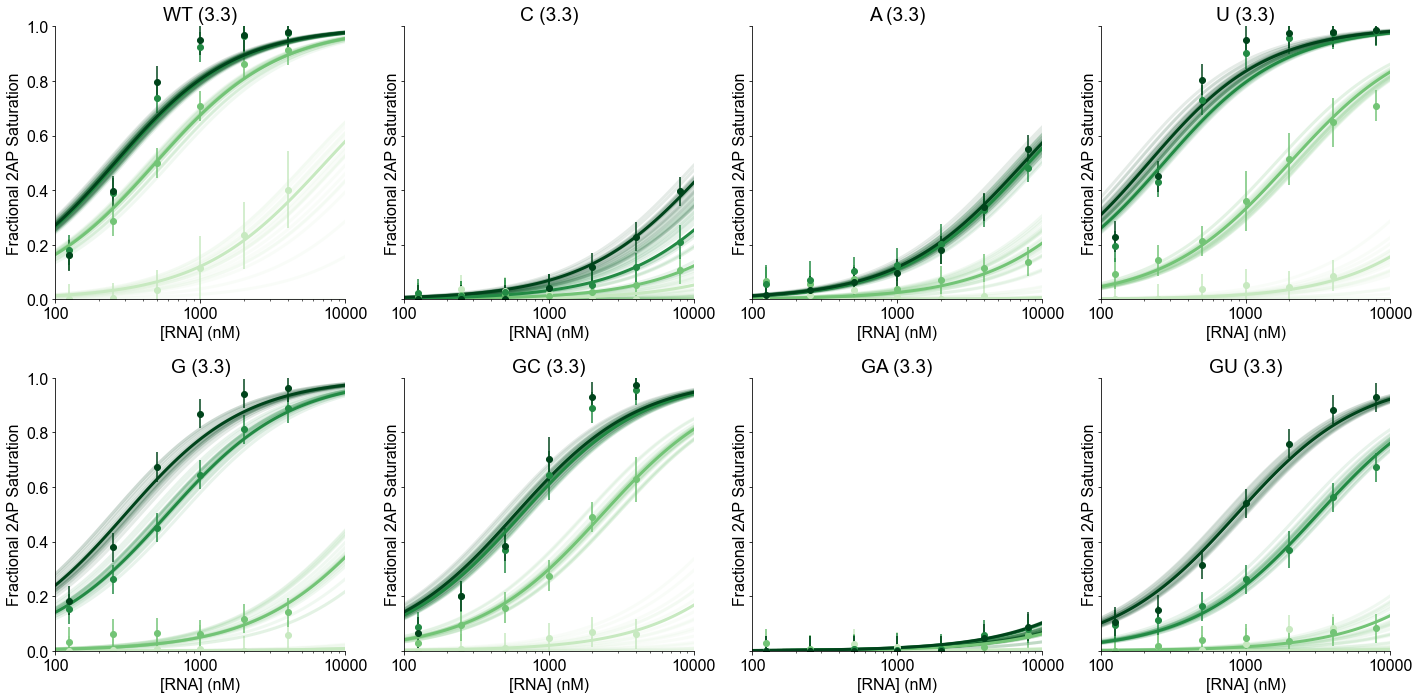

In [434]:
plot_groupedfits(model='3.3',fitter='bayesian',points=True,samples=True,ml_estimates=True,trimmed=True)

## Analysis functions (across Mg2+ concentration range)

In [19]:
def species_frac(k_estimates,model='3.3',Rt=RNA_nM,At=ADE_nM,Mt=MG_RANGE_nM):
    '''Get RNA fractional populations across Mg concentration range given fit estimates.'''
    
    if model.startswith('4'): 
        species = four_state_five_param.species_conc(*k_estimates,Rt=Rt,At=At,Mt=Mt)
    elif model == '3.4':
        species = three_state_four_param.species_conc(*k_estimates,Rt=Rt,At=At,Mt=Mt)
    elif model == '3.3':
        species = three_state_three_param.species_conc(*k_estimates,Rt=Rt,At=At,Mt=Mt)
    elif model == '2.3':
        species = two_state_three_param.species_conc(*k_estimates,Rt=Rt,At=At,Mt=Mt)

    # Remove free_M and free_A from species list
    rna_species = species[:-2]  
    species_frac = rna_species / np.float64(Rt)
    return species_frac

def species_energy(k_estimates,model='3.3',Rt=RNA_nM,At=ADE_nM,Mt=MG_RANGE_nM):
    '''Get RNA free energies across Mg concentration range given fit estimates.
    
    Free energies calculated by calling species_frac for RNA fractional populations.
    '''
    
    rna_fractions = species_frac(k_estimates,model=model,Rt=Rt,At=At,Mt=Mt)
    species_energy = -R*T*np.log(rna_fractions)
    return species_energy

def logk_to_k(model_df,k_nM=False):
    '''Convert logK parameter values in a DataFrame to non-logged nM^-1 or M^-1 units'''
    
    k_df = model_df.copy(deep=True)
    logk_df = model_df.loc[model_df.param != 'n_mg',['estimate','low_95','high_95']]
    name_series = model_df.loc[model_df.param != 'n_mg','param']
    
    
    if k_nM:
        logk_to_k = 10**logk_df
        logname_to_kname = name_series.str.replace('logK','(nM^-1)K')
        k_df.loc[model_df.param != 'n_mg','param'] = logname_to_kname
    else:
        logk_to_k = (10**logk_df)*1e9

    k_df.loc[model_df.param != 'n_mg',['estimate','low_95','high_95']] = logk_to_k

    return k_df

def logk_to_k_samples(logk_arr,k_nM=False):
    '''Convert logK parameter values in a numpy array to non-logged nM^-1 or M^-1 units'''
    
    k_arr = copy.deepcopy(logk_arr)
    if k_nM:
        k_arr[:,:-1] = 10**k_arr[:,:-1] # leave n_mg alone
    else:
        k_arr[:,:-1] = (10**k_arr[:,:-1])*1e9
    return k_arr
    
def logk_to_dg(model_df):
    '''Convert logK parameter values in a DataFrame to kcal/mol free energy units'''

    dg_df = model_df.copy(deep=True)
    logk_df = model_df.loc[model_df.param != 'n_mg',['estimate','low_95','high_95']] 
    logk_to_dg = -R*T*np.log((10**logk_df)*1e9)
    dg_df.loc[model_df.param != 'n_mg',['estimate','low_95','high_95']] = logk_to_dg
    
    name_series = model_df.loc[model_df.param != 'n_mg','param']
    logname_to_dgname = name_series.str.replace('logK','dG')
    dg_df.loc[model_df.param != 'n_mg','param'] = logname_to_dgname

    return dg_df

def logk_to_dg_samples(logk_arr):
    '''Convert logK parameter values in a numpy array to kcal/mol free energy units'''
    
    dg_arr = copy.deepcopy(logk_arr)
    dg_arr[:,:-1] = -R*T*np.log((10**dg_arr[:,:-1])*1e9) # leave n_mg alone
    return dg_arr

def k_epistasis(cycles=CYCLES,model='3.3',fitter='ml',dg=False,logK=False,k_nM=False):
    '''
    Generate Dataframe with epistasis within each fit parameter for each mutant cycle given
    a model and fitter.
    
    Epistasis units in kcal/mol (dg=True), log(nM^-1) (logK=True), nM^-1 (k_nM=True), or M^-1 (k_nM=False).
    '''

    param_ep_list = []
    model_df = get_model_results(model=model,fitter=fitter)
    
    for cycle in cycles:
        cycle_df = model_df.loc[model_df.Geno.isin(CYCLE_DICT[cycle])].copy(deep=True)
        g0,g1,g2,g12 = [g for g in CYCLE_DICT[cycle]]
        
        if dg:
            cycle_df = logk_to_dg(cycle_df)

        for param in cycle_df.param.unique():
            p0 = cycle_df.loc[(cycle_df.param == param) & (cycle_df.Geno == g0)]
            p1 = cycle_df.loc[(cycle_df.param == param) & (cycle_df.Geno == g1)]
            p2 = cycle_df.loc[(cycle_df.param == param) & (cycle_df.Geno == g2)]
            p12 = cycle_df.loc[(cycle_df.param == param) & (cycle_df.Geno == g12)]

            epistasis = (p12.estimate - p2.estimate) - (p1.estimate - p0.estimate)
            ep_low_95 = (p12.low_95 - p2.low_95) - (p1.low_95 - p0.low_95)
            ep_high_95 = (p12.high_95 - p2.high_95) - (p1.high_95 - p0.high_95)
            
            param_ep_df = pd.DataFrame({'cycle':cycle,
                                       'param':param,
                                       'estimate':epistasis,
                                       'low_95':ep_low_95,
                                       'high_95':ep_high_95})
            if (not dg) and (not logK):
                param_ep_df = logk_to_k(param_ep_df,k_nM=k_nM)
                
            param_ep_list.append(param_ep_df)

    k_epistasis_df = pd.concat(param_ep_list)
        
    return k_epistasis_df

def k_epistasis_samples(cycles,model='3.3',fitter='bayesian',dg=False,k_nM=False,logK=False,trimmed=True):
    '''
    Generate dictionary with epistasis within each fit parameter for each mutant cycle given
    a model and fitter.
    
    Epistasis units in kcal/mol (dg=True), log(nM^-1) (logK=True), nM^-1 (k_nM=True), or M^-1 (k_nM=False).
    '''
    
    sample_dict = get_model_samples(model=model,fitter=fitter,trimmed=trimmed)
    param_ep_dict = {}
    
    for cycle in cycles:
        cycle_samples = {geno:sample_arr for geno,sample_arr in sample_dict.items() if geno in CYCLE_DICT[cycle]}
        g0,g1,g2,g12 = [g for g in CYCLE_DICT[cycle]]

        if dg:
            cycle_samples = {geno:logk_to_dg_samples(sample_arr) for geno,sample_arr in cycle_samples.items()}

        param_epistasis = (cycle_samples[g12] - cycle_samples[g2]) - (cycle_samples[g1] - cycle_samples[g0])

        if (not dg) and (not logK):
            param_epistasis = logk_to_k_samples(param_epistasis,k_nM=k_nM)
        
        param_ep_dict[cycle] = param_epistasis
        
    return param_ep_dict

def g_obs(k_estimates,model='3.3',Rt=RNA_nM,At=ADE_nM,Mt=MG_RANGE_nM):
    '''
    Calculates experimental observable (free energy of 2AP-bound relative to 
    2AP-unbound RNA species) across Mg2+ range for given fit estimates and model.
    
    Calls species_energy to get free energy of each RNA species.
    '''
    
    if model.startswith('4'):
        gE,gD,gEA,gDA = species_energy(k_estimates,model=model,Rt=Rt,At=At,Mt=Mt)
        bound_part = np.exp(-BETA*gEA) + np.exp(-BETA*gDA) 
        unbound_part = np.exp(-BETA*gE) + np.exp(-BETA*gD)
        
    elif model.startswith('3'):
        gE,gD,gDA = species_energy(k_estimates,model=model,Rt=Rt,At=At,Mt=Mt)
        bound_part = np.exp(-BETA*gDA) 
        unbound_part = np.exp(-BETA*gE) + np.exp(-BETA*gD)
        
    elif model.startswith('2'):
        gE,gDA = species_energy(k_estimates,model=model,Rt=Rt,At=At,Mt=Mt)
        bound_part = np.exp(-BETA*gDA) 
        unbound_part = np.exp(-BETA*gE)
        
    g_obs = -R*T*np.log(bound_part / unbound_part)
    
    return g_obs

def g_obs_ensemble_only(k_est_list,model='3.3',Rt=RNA_nM,At=ADE_nM,Mt=MG_RANGE_nM):
    '''
    Calculates additive experimental observable for double mutant
    (free energy of 2AP-bound relative to 2AP-unbound RNA species) across Mg2+ range 
    by summing together species energies from wildtype and single mutant fit estimates.
    
    Calls species_energy to get free energy of each RNA species.
    Additive double mutant energies given by mut1 + mut2 - wt.
    
    k_est_list = [df0.estimate,df1.estimate,df2.estimate]
    '''
    
    if model.startswith('4'):
        gE0,gD0,gEA0,gDA0 = species_energy(k_est_list[0],model=model,Rt=Rt,At=At,Mt=Mt)
        gE1,gD1,gEA1,gDA1 = species_energy(k_est_list[1],model=model,Rt=Rt,At=At,Mt=Mt)
        gE2,gD2,gEA2,gDA2 = species_energy(k_est_list[2],model=model,Rt=Rt,At=At,Mt=Mt)
        
        bound_part = np.exp(-BETA*(gEA1+gEA2-gEA0)) + np.exp(-BETA*(gDA1+gDA2-gDA0)) 
        unbound_part = np.exp(-BETA*(gE1+gE2-gE0)) + np.exp(-BETA*(gD1+gD2-gD0))
        
    elif model.startswith('3'):
        gE0,gD0,gDA0 = species_energy(k_est_list[0],model=model,Rt=Rt,At=At,Mt=Mt)
        gE1,gD1,gDA1 = species_energy(k_est_list[1],model=model,Rt=Rt,At=At,Mt=Mt)
        gE2,gD2,gDA2 = species_energy(k_est_list[2],model=model,Rt=Rt,At=At,Mt=Mt)
        
        bound_part = np.exp(-BETA*(gDA1+gDA2-gDA0)) 
        unbound_part = np.exp(-BETA*(gE1+gE2-gE0)) + np.exp(-BETA*(gD1+gD2-gD0))
        
    elif model.startswith('2'):
        gE0,gDA0 = species_energy(k_est_list[0],model=model,Rt=Rt,At=At,Mt=Mt)
        gE1,gDA1 = species_energy(k_est_list[1],model=model,Rt=Rt,At=At,Mt=Mt)
        gE2,gDA2 = species_energy(k_est_list[2],model=model,Rt=Rt,At=At,Mt=Mt)
        
        bound_part = np.exp(-BETA*(gDA1+gDA2-gDA0)) 
        unbound_part = np.exp(-BETA*(gE1+gE2-gE0)) 
        
    g_obs_ensemble_only = -R*T*np.log(bound_part / unbound_part)
    
    return g_obs_ensemble_only


def obs_epistasis(cycles=CYCLES,model='3.3',fitter='bayesian',
                  Rt=RNA_nM,At=ADE_nM,Mt=MG_RANGE_nM,
                  total=False,ensemble_only=False,ep_mg=False,ep_2AP=False):
    '''
    Generates DataFrame with epistasis in the experimental observable (g_obs) for 
    each mutant cycle across the Mg2+ concentration range for a given model and fitter.
    
    Can specify total epistasis (total=True), additive ensemble epistasis (ensemble_only=True),
    or add contact epistasis in Mg-binding (ep_mg=True) or 2AP-binding (ep_2AP=True).
    
    For ensemble_only: calls g_obs_ensemble_only to get observable for double mutant 
    Otherwise: calls g_obs for all genotypes
    '''
    
    obs_ep_list = []
    for cycle in cycles:
        g0,g1,g2,g12 = [g for g in CYCLE_DICT[cycle]]
        
        model_df = get_model_results(model=model,fitter=fitter)
        cycle_df = model_df.loc[model_df.Geno.isin(CYCLE_DICT[cycle])].copy(deep=True)

        df0 = cycle_df.loc[cycle_df.Geno == g0]
        df1 = cycle_df.loc[cycle_df.Geno == g1]
        df2 = cycle_df.loc[cycle_df.Geno == g2]
        df12 = cycle_df.loc[cycle_df.Geno == g12]


        obs0 = g_obs(df0.estimate,model=model,Rt=Rt,At=At,Mt=Mt)
        obs1 = g_obs(df1.estimate,model=model,Rt=Rt,At=At,Mt=Mt)
        obs2 = g_obs(df2.estimate,model=model,Rt=Rt,At=At,Mt=Mt)

        if total:
            obs12 = g_obs(df12.estimate,model=model,Rt=Rt,At=At,Mt=Mt)

        elif ensemble_only:
            k_est_list = [df0.estimate,df1.estimate,df2.estimate]
            obs12 = g_obs_ensemble_only(k_est_list,model=model,Rt=Rt,At=At,Mt=Mt)
            
        elif (ep_mg) or (ep_2AP):
            k_ep_df = k_epistasis(cycles=[cycle],model=model,fitter=fitter,logK=True)
            df12_edit = df12.copy(deep=True)
            
            if ep_mg:
                remove_ep_part = k_ep_df.loc[~k_ep_df.param.isin(['logK_mg','n_mg'])]        
            elif ep_2AP:
                remove_ep_part = k_ep_df.loc[~(k_ep_df.param == 'logK_2AP')]
                
            non_ep_df12 = df12_edit.loc[df12_edit.param.isin(remove_ep_part.param)]
            removed_epistasis = non_ep_df12.estimate - remove_ep_part.estimate
            df12_edit.loc[df12_edit.param.isin(remove_ep_part.param),'estimate'] = removed_epistasis
            obs12 = g_obs(df12_edit.estimate,model=model,Rt=Rt,At=At,Mt=Mt)
                

        epistasis = (obs12 - obs2) - (obs1 - obs0)

        obs_ep_list.append(pd.DataFrame({'cycle':cycle,
                                         'total_ep?':total,
                                         'obs_epistasis':epistasis}))

    obs_epistasis_df = pd.concat(obs_ep_list)
        
    return obs_epistasis_df

def obs_epistasis_samples(cycles,model,fitter,sample_frac=0.05,trimmed=True,
                          Rt=RNA_nM,At=ADE_nM,Mt=MG_RANGE_nM,
                          total=False,ensemble_only=False):
    '''
    Generates dictionary with epistasis in the experimental observable (g_obs) for 
    each mutant cycle across the Mg2+ concentration range for a given model and fitter.
    
    Can specify total epistasis (total=True or additive ensemble epistasis (ensemble_only=True)
    '''
    
    sample_dict = get_model_samples(model=model,fitter=fitter,trimmed=trimmed)
    obs_ep_dict = {}
    
    for cycle in cycles:
        cycle_samples = {geno:sample_arr for geno,sample_arr in sample_dict.items() if geno in CYCLE_DICT[cycle]}
        g0,g1,g2,g12 = [g for g in CYCLE_DICT[cycle]]
        
        spacing = int(sample_frac*cycle_samples[g0].shape[0])
            
        sample_positions = np.arange(0,cycle_samples[g0].shape[0],spacing)
        obs_ep_arr = np.zeros((sample_positions.shape[0],Mt.shape[0]))
            
        for i,pos in enumerate(sample_positions):
            
            obs0 = g_obs(cycle_samples[g0][pos],model=model,Rt=Rt,At=At,Mt=Mt)
            obs1 = g_obs(cycle_samples[g1][pos],model=model,Rt=Rt,At=At,Mt=Mt)
            obs2 = g_obs(cycle_samples[g2][pos],model=model,Rt=Rt,At=At,Mt=Mt)
            
            if total:
                obs12 = g_obs(cycle_samples[g12][pos],model=model,Rt=Rt,At=At,Mt=Mt)

            elif ensemble_only:
                k_est_list = [cycle_samples[g0][pos],cycle_samples[g1][pos],cycle_samples[g2][pos]]
                obs12 = g_obs_ensemble_only(k_est_list,model=model,Rt=Rt,At=At,Mt=Mt)
        
            epistasis = (obs12 - obs2) - (obs1 - obs0)
            obs_ep_arr[i,:] = epistasis
        
        obs_ep_dict[cycle] = obs_ep_arr
        
    return obs_ep_dict
        
def kapp_epistasis(cycles,model='kapp',fitter='ml'):
    '''
    Generates DataFrame with epistasis specific to the kapp model at 
    four discrete Mg2+ concentrations (0.1,1,10,100 mM).
    
    Epistasis with respect to 2AP binding calculated from the single Kapp fit parameter,
    as well as for the 96 percent confidence interval.
    '''
    
    kapp_ep_list = []
    for cycle in cycles:
        g0,g1,g2,g12 = [g for g in CYCLE_DICT[cycle]]
        
    
        model_df = get_model_results(model=model,fitter=fitter)
        cycle_df = model_df.loc[model_df.Geno.isin(CYCLE_DICT[cycle])].copy(deep=True)
        cycle_df = logk_to_dg(cycle_df)

        df0 = cycle_df.loc[cycle_df.Geno == g0]
        df1 = cycle_df.loc[cycle_df.Geno == g1]
        df2 = cycle_df.loc[cycle_df.Geno == g2]
        df12 = cycle_df.loc[cycle_df.Geno == g12]
        
        apparent_ep = (df12.estimate - df2.estimate) - (df1.estimate - df0.estimate)
        ep_low_95 = (df12.low_95 - df2.low_95) - (df1.low_95 - df0.low_95)
        ep_high_95 = (df12.high_95 - df2.high_95) - (df1.high_95 - df0.high_95)
        
        kapp_ep_list.append(pd.DataFrame({'cycle':cycle,
                                         'Mg':df0.Mg,
                                         'apparent_ep':apparent_ep,
                                         'ep_low_95':ep_low_95,
                                         'ep_high_95':ep_high_95}))
        
    kapp_epistasis_df = pd.concat(kapp_ep_list)
    return kapp_epistasis_df

## Single plotting functions

In [484]:
def plot_pops(geno,model,fitter,ml_estimates=False,samples=False,sample_frac=0.05,trimmed=True,
              Rt=RNA_nM,At=ADE_nM,Mt=MG_RANGE_nM,
              alpha=1,ax=None,title=None,legend=True):
    
    pos_dict = {0:'E',1:'D',2:'EA',-1:'DA'}
    
    if ml_estimates:
        model_df = get_model_results(model=model,fitter='ml')
        model_geno_df = model_df.loc[model_df.Geno == geno]
    
        rna_fractions = species_frac(model_geno_df.estimate,model=model,Rt=Rt,At=At,Mt=Mt)
        ax.plot(Mt*1e-6,rna_fractions[0],lw=3,alpha=alpha,color='orange',label='E')
        if len(rna_fractions) >= 4:
            ax.plot(Mt*1e-6,rna_fractions[2],lw=3,alpha=alpha,color='gray',label='EA')
        if len(rna_fractions) >= 3: 
            ax.plot(Mt*1e-6,rna_fractions[1],lw=3,alpha=alpha,color='cornflowerblue',label='D')
        ax.plot(Mt*1e-6,rna_fractions[-1],lw=3,alpha=alpha,color='purple',label='DA')
        
    if samples:
        sample_dict = get_model_samples(model=model,fitter=fitter,trimmed=trimmed)
        geno_arr = sample_dict[geno]
        
        spacing = int(sample_frac*geno_arr.shape[0])
        alpha=0.1

        sample_positions = np.arange(0,geno_arr.shape[0],spacing)
        for pos in sample_positions:
            rna_fractions = species_frac(geno_arr[pos],model=model,Rt=Rt,At=At,Mt=Mt)
            ax.plot(Mt*1e-6,rna_fractions[0],lw=3,alpha=alpha,color='orange',label='_nolegend_')
            if len(rna_fractions) >= 4:
                ax.plot(Mt*1e-6,rna_fractions[2],lw=3,alpha=alpha,color='gray',label='_nolegend_')
            if len(rna_fractions) >= 3: 
                ax.plot(Mt*1e-6,rna_fractions[1],lw=3,alpha=alpha,color='cornflowerblue',label='_nolegend_')
            ax.plot(Mt*1e-6,rna_fractions[-1],lw=3,alpha=alpha,color='purple',label='_nolegend_')
    
    ax.set_title(title)
    ax.set_xscale('log')
    ax.set_xlabel('[Mg] (mM)')
    ax.set_ylabel('Fractional Population')
    ax.set_ylim(0,1)
    ax.xaxis.set_major_formatter(ScalarFormatter())
    if legend:
        ax.legend(loc='best',fontsize='x-small')

    return None

            
def plot_energies(geno,model,fitter,ml_estimates=False,samples=False,sample_frac=0.05,trimmed=True,
                  Rt=RNA_nM,At=ADE_nM,Mt=MG_RANGE_nM,
                  alpha=1,ax=None,ylim=None,title=None,legend=True):
    
    pos_dict = {0:'E',1:'D',2:'EA',-1:'DA'}
    
    if ml_estimates:
        model_df = get_model_results(model=model,fitter='ml')
        model_geno_df = model_df.loc[model_df.Geno == geno]
    
        rna_energies = species_energy(model_geno_df.estimate,model=model,Rt=Rt,At=At,Mt=Mt)
        ax.plot(Mt*1e-6,rna_energies[0],lw=3,alpha=alpha,color='orange',label='E')
        if len(rna_energies) >= 4:
            ax.plot(Mt*1e-6,rna_energies[2],lw=3,alpha=alpha,color='gray',label='EA')
        if len(rna_energies) >= 3: 
            ax.plot(Mt*1e-6,rna_energies[1],lw=3,alpha=alpha,color='cornflowerblue',label='D')
        ax.plot(Mt*1e-6,rna_energies[-1],lw=3,alpha=alpha,color='purple',label='DA')
        
    elif samples:
        sample_dict = get_model_samples(model=model,fitter=fitter,trimmed=trimmed)
        geno_arr = sample_dict[geno]
        
        spacing = int(sample_frac*geno_arr.shape[0])
        alpha=0.1
            
        sample_positions = np.arange(0,geno_arr.shape[0],spacing)
        for pos in sample_positions:
            rna_energies = species_energy(geno_arr[pos],model=model,Rt=Rt,At=At,Mt=Mt)
            ax.plot(Mt*1e-6,rna_energies[0],lw=3,alpha=alpha,color='orange',label='_nolegend_')
            if len(rna_energies) >= 4:
                ax.plot(Mt*1e-6,rna_energies[2],lw=3,alpha=alpha,color='gray',label='_nolegend_')
            if len(rna_energies) >= 3: 
                ax.plot(Mt*1e-6,rna_energies[1],lw=3,alpha=alpha,color='cornflowerblue',label='_nolegend_')
            ax.plot(Mt*1e-6,rna_energies[-1],lw=3,alpha=alpha,color='purple',label='_nolegend_')

    ax.set_title(title)
    ax.axhline(color='black',lw=1)
    ax.set_xscale('log')
    ax.set_xlabel('[Mg] (mM)')
    ax.set_ylabel('dG')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    if ylim is not None:
        ax.set_ylim(ylim)
    if legend:
        ax.legend(loc='best',fontsize='x-small')

    return None

def plot_k(geno,model,fitter,dg=False,k_nM=False,logK=False,
           samples=False,trimmed=True,ninetyfive=False,ylim=None,
           ax=None,title=None,legend=True):
    
    model_df = get_model_results(model=model,fitter=fitter)
    model_geno_df = model_df.loc[model_df.Geno == geno]
    x_spacing = np.arange(len(model_geno_df.param.unique()))
    
    if dg:
        conv_df = logk_to_dg(model_geno_df)
    elif logK:
        conv_df = model_geno_df.copy(deep=True)
    elif (not dg) and (not logK):
        conv_df = logk_to_k(model_geno_df,k_nM=k_nM)
                          
    conv_df.plot.bar(x='param',y='estimate',ax=ax,alpha=0.5,legend=False)
    
    if ninetyfive:
        ax.vlines(x_spacing,conv_df.low_95,conv_df.high_95,color='black')
           
    if samples:
        sample_dict = get_model_samples(model=model,fitter='bayesian',trimmed=trimmed)
        geno_arr = sample_dict[geno]
        if dg:
            geno_arr = logk_to_dg_samples(geno_arr)
        if (not dg) and (not logK):
            geno_arr = logk_to_k_samples(geno_arr,k_nM=k_nM)
            
        for i,pos in enumerate(x_spacing):
            x = [pos]*geno_arr.shape[0]
            ax.scatter(x,geno_arr[:,i],color='orange',alpha=0.5,linewidth=0.5,s=1)
        
    ax.set_title(title)
    if dg:
        ax.axhline(color='black',lw=1)
        ax.set_ylabel('dG (kcal/mol)')
    elif logK:
        ax.axhline(color='black',lw=1)
        ax.set_ylabel('logK (nM^-1)')
    else:
        ax.axhline(1,color='black',lw=1)
        ax.set_yscale('log')
        if k_nM:
            ax.set_ylabel('K (nM^-1)')
        else:
            ax.set_ylabel('K (M^-1)')
    if ylim is not None:
        ax.set_ylim(ylim)
    return None

def plot_k_epistasis(cycle,model,fitter,dg=False,k_nM=False,logK=False,trimmed=True,
                     samples=False,ninetyfive=False,ylim=None,ax=None,title=None,legend=True):
    
    k_epistasis_df = k_epistasis(cycles=[cycle],model=model,fitter=fitter,dg=dg,k_nM=k_nM,logK=logK)
    x_spacing = np.arange(len(k_epistasis_df.param.unique()))
    k_epistasis_df.plot.bar(x='param',y='estimate',ax=ax,alpha=0.5,legend=False)
    
    if ninetyfive:
        ax.vlines(x_spacing,k_epistasis_df.low_95,k_epistasis_df.high_95,color='black')
        
    if samples:
        cycle_ep_dict = k_epistasis_samples(cycles=[cycle],model=model,fitter='bayesian',dg=dg,k_nM=k_nM,logK=logK,trimmed=trimmed)
        ep_arr = cycle_ep_dict[cycle]
        for i,pos in enumerate(x_spacing):
            x = [pos]*ep_arr.shape[0]
            ax.scatter(x,ep_arr[:,i],color='orange',alpha=0.5,linewidth=0.5,s=1)
        
    ax.set_title(title)
    
    if dg:
        ax.axhline(color='black',lw=1)
        ax.set_ylabel('Epistasis (kcal/mol)')
    elif logK:
        ax.axhline(color='black',lw=1)
        ax.set_ylabel('Epistasis (log(nM-1))')
    else:
        ax.axhline(1,color='black',lw=1)
        ax.set_yscale('log')
        if k_nM:
            ax.set_ylabel('Epistasis (nM^-1)')
        else:
            ax.set_ylabel('Epistasis (M^-1)')
    if ylim is not None:
        ax.set_ylim(ylim)
    return None

def plot_obs_epistasis(cycle,model,fitter,samples=False,ml_estimates=False,ninetyfive=False,
                       total=False,ensemble_only=False,ep_mg=False,ep_2AP=False,
                       kapp=False,sample_frac=0.05,trimmed=True,
                       alpha=1,ylim=None,ax=None,title=None,legend=True):
    
    if ml_estimates:
        if total:
            total_ep_df = obs_epistasis(cycles=[cycle],model=model,fitter='ml',total=True)
            ax.plot(MG_RANGE_mM,total_ep_df.obs_epistasis,lw=3,alpha=alpha,color='blue',label='total')
            if ninetyfive:
                ax.fill_between(MG_RANGE_mM,total_ep_df.ep_low_95,total_ep_df.ep_high_95,alpha=0.1,color='blue') 
        if ensemble_only:
            ensemble_only_df = obs_epistasis(cycles=[cycle],model=model,fitter='ml',ensemble_only=True)
            ax.plot(MG_RANGE_mM,ensemble_only_df.obs_epistasis,lw=3,alpha=alpha,color='red',label='ensemble only')
            if ninetyfive:
                ax.fill_between(MG_RANGE_mM,ensemble_only_df.ep_low_95,ensemble_only_df.ep_high_95,alpha=0.1,color='red')
        if ep_mg:
            ep_mg_df = obs_epistasis(cycles=[cycle],model=model,fitter='ml',ep_mg=True)
            ax.plot(MG_RANGE_mM,ep_mg_df.obs_epistasis,lw=3,alpha=alpha,color='orange',label='ep_mg')
        if ep_2AP:
            ep_2AP_df = obs_epistasis(cycles=[cycle],model=model,fitter='ml',ep_2AP=True)
            ax.plot(MG_RANGE_mM,ep_2AP_df.obs_epistasis,lw=3,alpha=alpha,color='pink',label='ep_2AP')
            

    if samples:
        sample_dict = get_model_samples(model=model,fitter=fitter,trimmed=trimmed)
        if total:
            total_ep_dict = obs_epistasis_samples(cycles=[cycle],model=model,fitter=fitter,sample_frac=sample_frac,total=True)
            for i in range(total_ep_dict[cycle].shape[0]):
                ax.plot(MG_RANGE_mM,total_ep_dict[cycle][i],lw=3,alpha=0.1,color='blue',label='_nolegend_')
        if ensemble_only:
            ensemble_only_dict = obs_epistasis_samples(cycles=[cycle],model=model,fitter=fitter,sample_frac=sample_frac,ensemble_only=True)
            for i in range(total_ep_dict[cycle].shape[0]):
                ax.plot(MG_RANGE_mM,ensemble_only_dict[cycle][i],lw=3,alpha=0.1,color='red',label='_nolegend_')
                
    else:
        if total:
            total_ep_df = obs_epistasis(cycles=[cycle],model=model,fitter=fitter,total=True)
            ax.plot(MG_RANGE_mM,total_ep_df.obs_epistasis,lw=3,alpha=alpha,color='blue',label='total')
        if ensemble_only:
            ensemble_only_df = obs_epistasis(cycles=[cycle],model=model,fitter=fitter,ensemble_only=True)
            ax.plot(MG_RANGE_mM,ensemble_only_df.obs_epistasis,lw=3,alpha=alpha,color='red',label='ensemble only')
        
    if kapp:
        kapp_ep_df = kapp_epistasis(cycles=[cycle])
        ax.scatter(kapp_ep_df.Mg,kapp_ep_df.apparent_ep,s=30,color='cyan',label='apparent')
        ax.vlines(kapp_ep_df.Mg,kapp_ep_df.ep_low_95,kapp_ep_df.ep_high_95,color='cyan')
            
    ax.set_title(title)
    ax.axhline(color='black',lw=1)
    ax.set_xscale('log')
    ax.set_xlabel('[Mg] (mM)')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.set_ylabel('Epistasis (kcal/mol)')
    if ylim is not None:
        ax.set_ylim(ylim)
    #else:
    #    ax.set_ylim(-5,5)
    ax.set_box_aspect(1)
    if legend:
        ax.legend(loc='lower right',fontsize='x-small')   

        

## Grouped plotting functions

In [20]:
def plot_geno_group(genos=GENOS,model='3.3',fitter='ml',samples=False,ml_estimates=False,
                    pops=False,energies=False,k_estimates=False,trimmed=True,
                    dg=False,k_nM=False,logK=False,ylim=False,ninetyfive=False,
                    sample_frac=0.05,alpha=1,legend=True,savefig=False,file=None):
    '''
    Organizing scheme for plots for all 8 genotypes (4 per row)
    
    Options: plot RNA species populations (pops=True), RNA species energies (energies=True),
    or parameter estimate bar charts (k_estiamtes=True).
    
    If bayesian samples are to be plotted, ml_estimates=True overlays the ML fit.
    '''

    fig, axes = plt.subplots(ncols=4,nrows=2,sharey=True,squeeze=False,figsize=(20,10)) 
    
    pbar = tqdm(range(8))
    for i in pbar:
        geno = genos[i]
        pbar.set_description("Plotting %s" % GENO_DICT[geno])
        
        #organize subplot layout 
        j = 0
        k = i
        if i >= 4:
            j = 1
            k = i-4
            
        if pops:
            plot_pops(geno=geno,model=model,fitter=fitter,samples=samples,
                      sample_frac=sample_frac,ml_estimates=ml_estimates,
                      trimmed=trimmed,alpha=alpha,ax=axes[j,k],
                      legend=legend,title=f'{GENO_DICT[geno]} ({model})')
        if energies:
            plot_energies(geno=geno,model=model,fitter=fitter,samples=samples,
                          sample_frac=sample_frac,ml_estimates=ml_estimates,
                          trimmed=trimmed,alpha=alpha,ax=axes[j,k],
                          legend=legend,title=f'{GENO_DICT[geno]} ({model})')         
        if k_estimates:
            plot_k(geno=geno,model=model,fitter=fitter,samples=samples,ninetyfive=ninetyfive,
                   trimmed=trimmed,dg=dg,k_nM=k_nM,logK=logK,ylim=ylim,
                   ax=axes[j,k],title=f'{GENO_DICT[geno]} ({model})') 
        
    fig.tight_layout()
    if savefig:
        fig.savefig(file)
        
    return None


def plot_geno_cycles(cycles=CYCLES,model='3.3',fitter='ml',samples=False,ml_estimates=False,
                     k_epistasis=False,obs_epistasis=False,total=False,ensemble_only=False,ep_mg=False,ep_2AP=False,
                     dg=False,k_nM=False,logK=False,ylim=None,ninetyfive=False,kapp=True,
                     sample_frac=0.05,trimmed=True,alpha=1,legend=True,savefig=False,file=None):
    '''
    Organizing scheme for plots for all three cycles (single row)
    
    Options: plot parameter epistasis bar charts (k_epistasis=True) or mg-dependent epistasis curves (obs_epistasis=True)
    For k_epistasis, can specify units (usually dg=True)
    For obs_epistasis, can specify which types (usually total=True, ensemble_only=True, kapp=True)
    
    If bayesian samples are to be plotted, ml_estimates=True overlays the ML fit.
    '''
    
    fig, axes = plt.subplots(ncols=3,nrows=1,sharex=True,sharey=True,
                             squeeze=False,figsize=(15,5))
    
    pbar = tqdm(cycles)
    for i,cycle in enumerate(pbar):
        pbar.set_description("processing %s" % cycles[i])
        
        if k_epistasis:
            plot_k_epistasis(cycle=cycle,model=model,fitter=fitter,dg=dg,k_nM=k_nM,logK=logK,
                             samples=samples,trimmed=trimmed,ninetyfive=ninetyfive,
                             ylim=ylim,ax=axes[0,i],title=cycle)
        
        if obs_epistasis:
            plot_obs_epistasis(cycle=cycle,model=model,fitter=fitter,samples=samples,
                               sample_frac=sample_frac,ml_estimates=ml_estimates,trimmed=trimmed,
                               kapp=kapp,total=total,ensemble_only=ensemble_only,ep_mg=ep_mg,ep_2AP=ep_2AP,
                               ax=axes[0,i],legend=legend,title=cycle)
            
    fig.tight_layout()
    if savefig:
        fig.savefig(file)
        
    return None


### Total epistasis plots

processing GU: 100%|██████████| 3/3 [00:09<00:00,  3.03s/it]


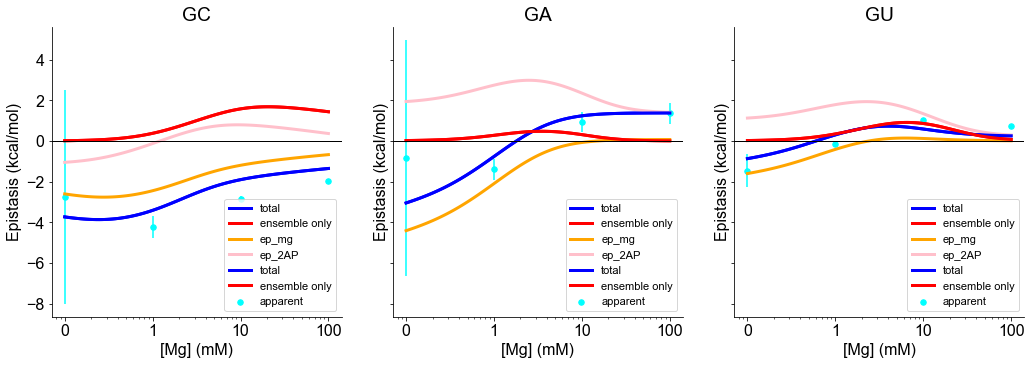

In [486]:
#run1
plot_geno_cycles(cycles=CYCLES,model='3.3',fitter='ml',samples=False,ml_estimates=True,
                 obs_epistasis=True,total=True,ensemble_only=True,ep_mg=True,ep_2AP=True,kapp=True)

processing GU: 100%|██████████| 3/3 [01:07<00:00, 22.34s/it]


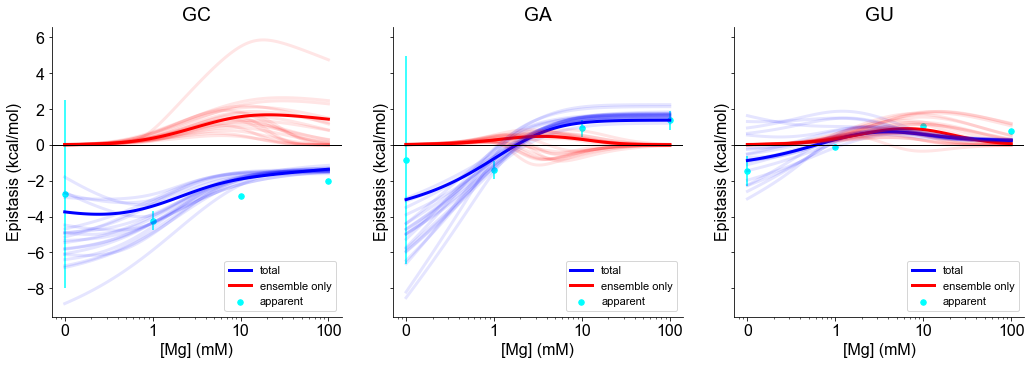

In [438]:
#run1
plot_geno_cycles(cycles=CYCLES,model='3.3',fitter='bayesian',samples=True,ml_estimates=True,
                 obs_epistasis=True,total=True,ensemble_only=True,kapp=True)

processing GU: 100%|██████████| 3/3 [01:07<00:00, 22.44s/it]


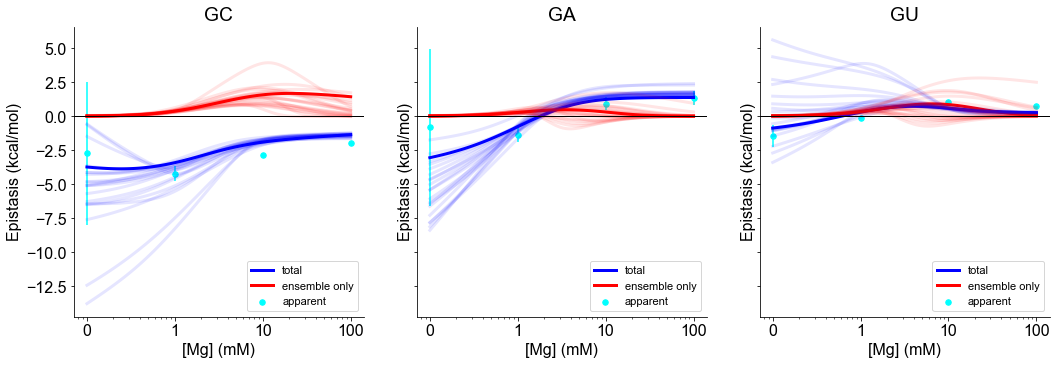

In [439]:
#run2
plot_geno_cycles(cycles=CYCLES,model='3.3',fitter='bayesian',samples=True,ml_estimates=True,
                 obs_epistasis=True,total=True,ensemble_only=True,kapp=True)

### Epistasis in equilibrium constants

processing GU: 100%|██████████| 3/3 [00:00<00:00, 16.18it/s]


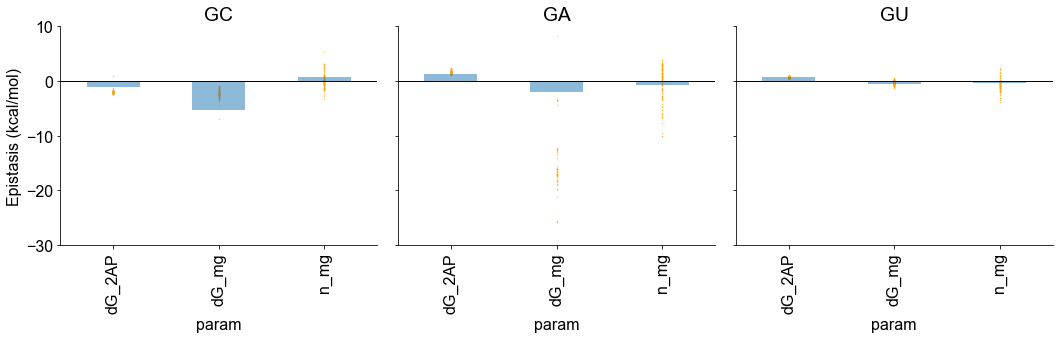

In [494]:
plot_geno_cycles(cycles=CYCLES,model='3.3',fitter='ml',samples=True,dg=True,
                 k_epistasis=True,ninetyfive=False,ylim=(-30,10))

processing GU: 100%|██████████| 3/3 [00:00<00:00, 18.93it/s]


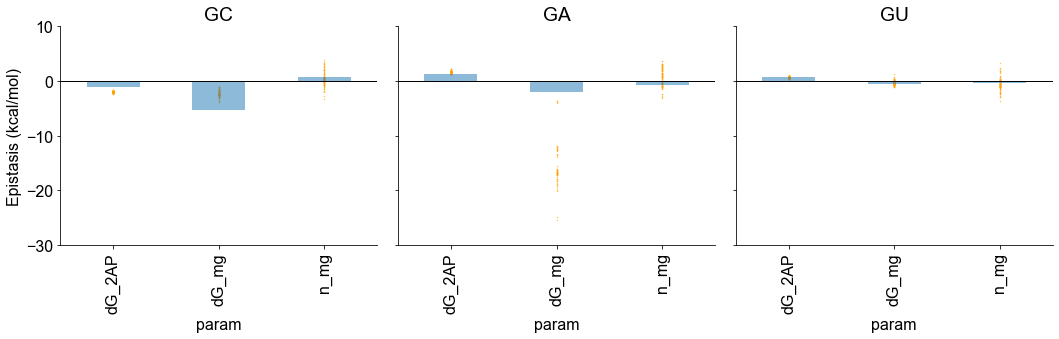

In [441]:
plot_geno_cycles(cycles=CYCLES,model='3.3',fitter='ml',samples=True,dg=True,
                 k_epistasis=True,ninetyfive=False,ylim=(-30,10))

### Equilibrium constants for all genos

Plotting GU: 100%|██████████| 8/8 [00:00<00:00, 16.99it/s]


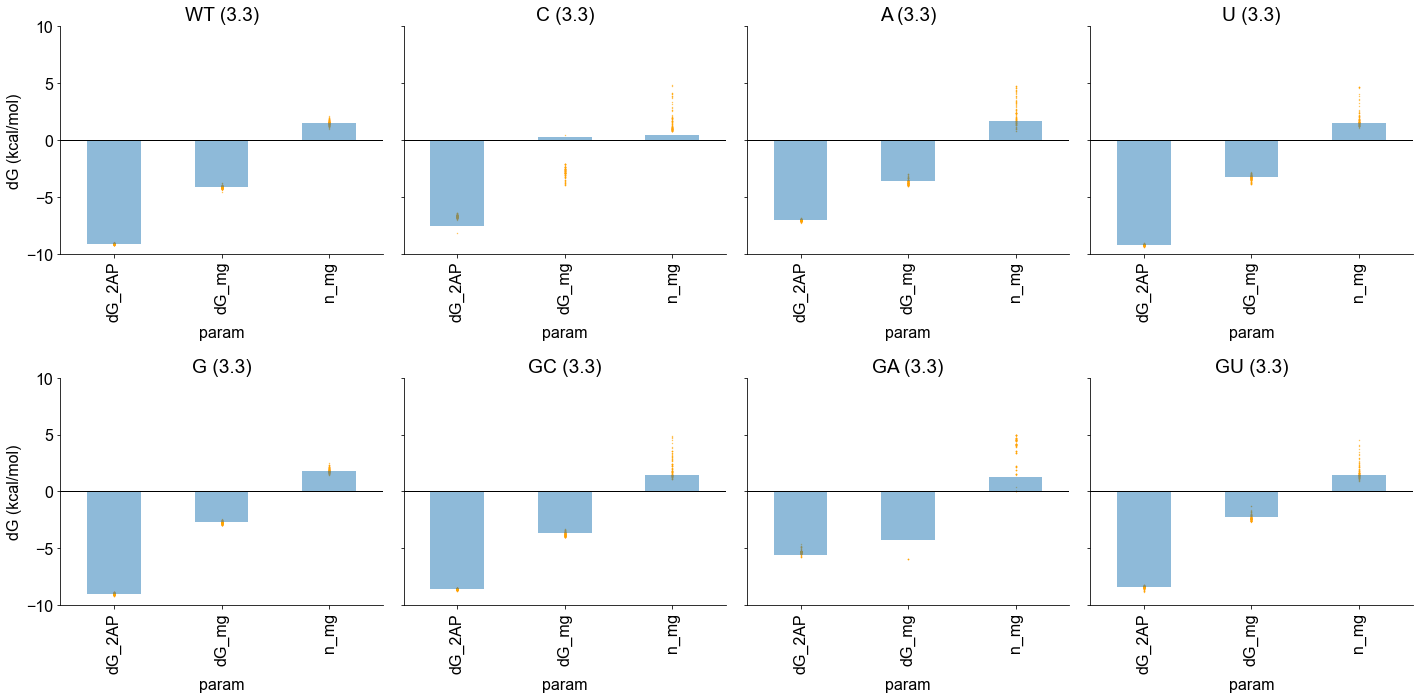

In [445]:
plot_geno_group(genos=GENOS,model='3.3',fitter='ml',samples=True,ninetyfive=False,k_estimates=True,dg=True,ylim=(-10,10))

### Species populations for all genos

Plotting GU: 100%|██████████| 8/8 [00:19<00:00,  2.48s/it]


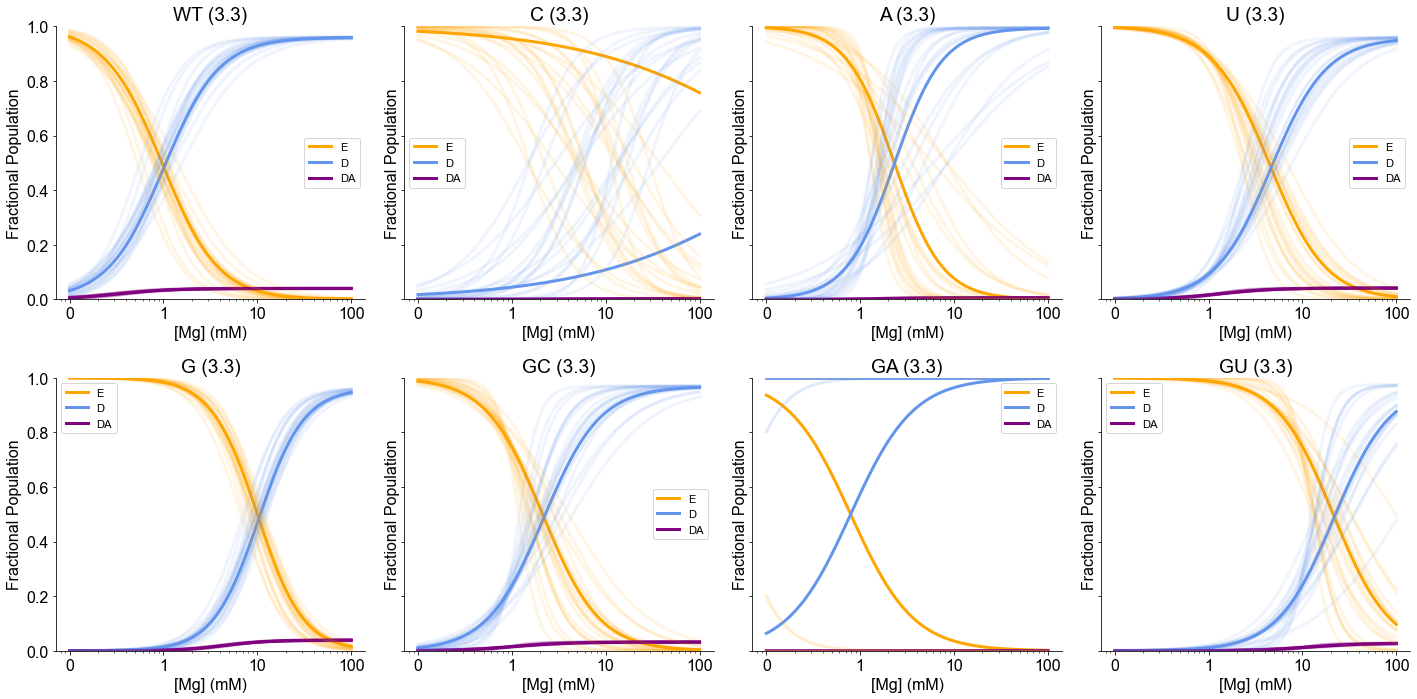

In [495]:
plot_geno_group(genos=GENOS,model='3.3',fitter='bayesian',samples=True,ml_estimates=True,pops=True)